
Hello this is a Neural network for a trivial task with the mnist dataset

In [16]:
import numpy as np
import struct
from array import array
from os.path  import join

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
    # Read labels
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        

        # Read images
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(rows, cols)  
            images.append(img)

        return images, labels
    
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)       


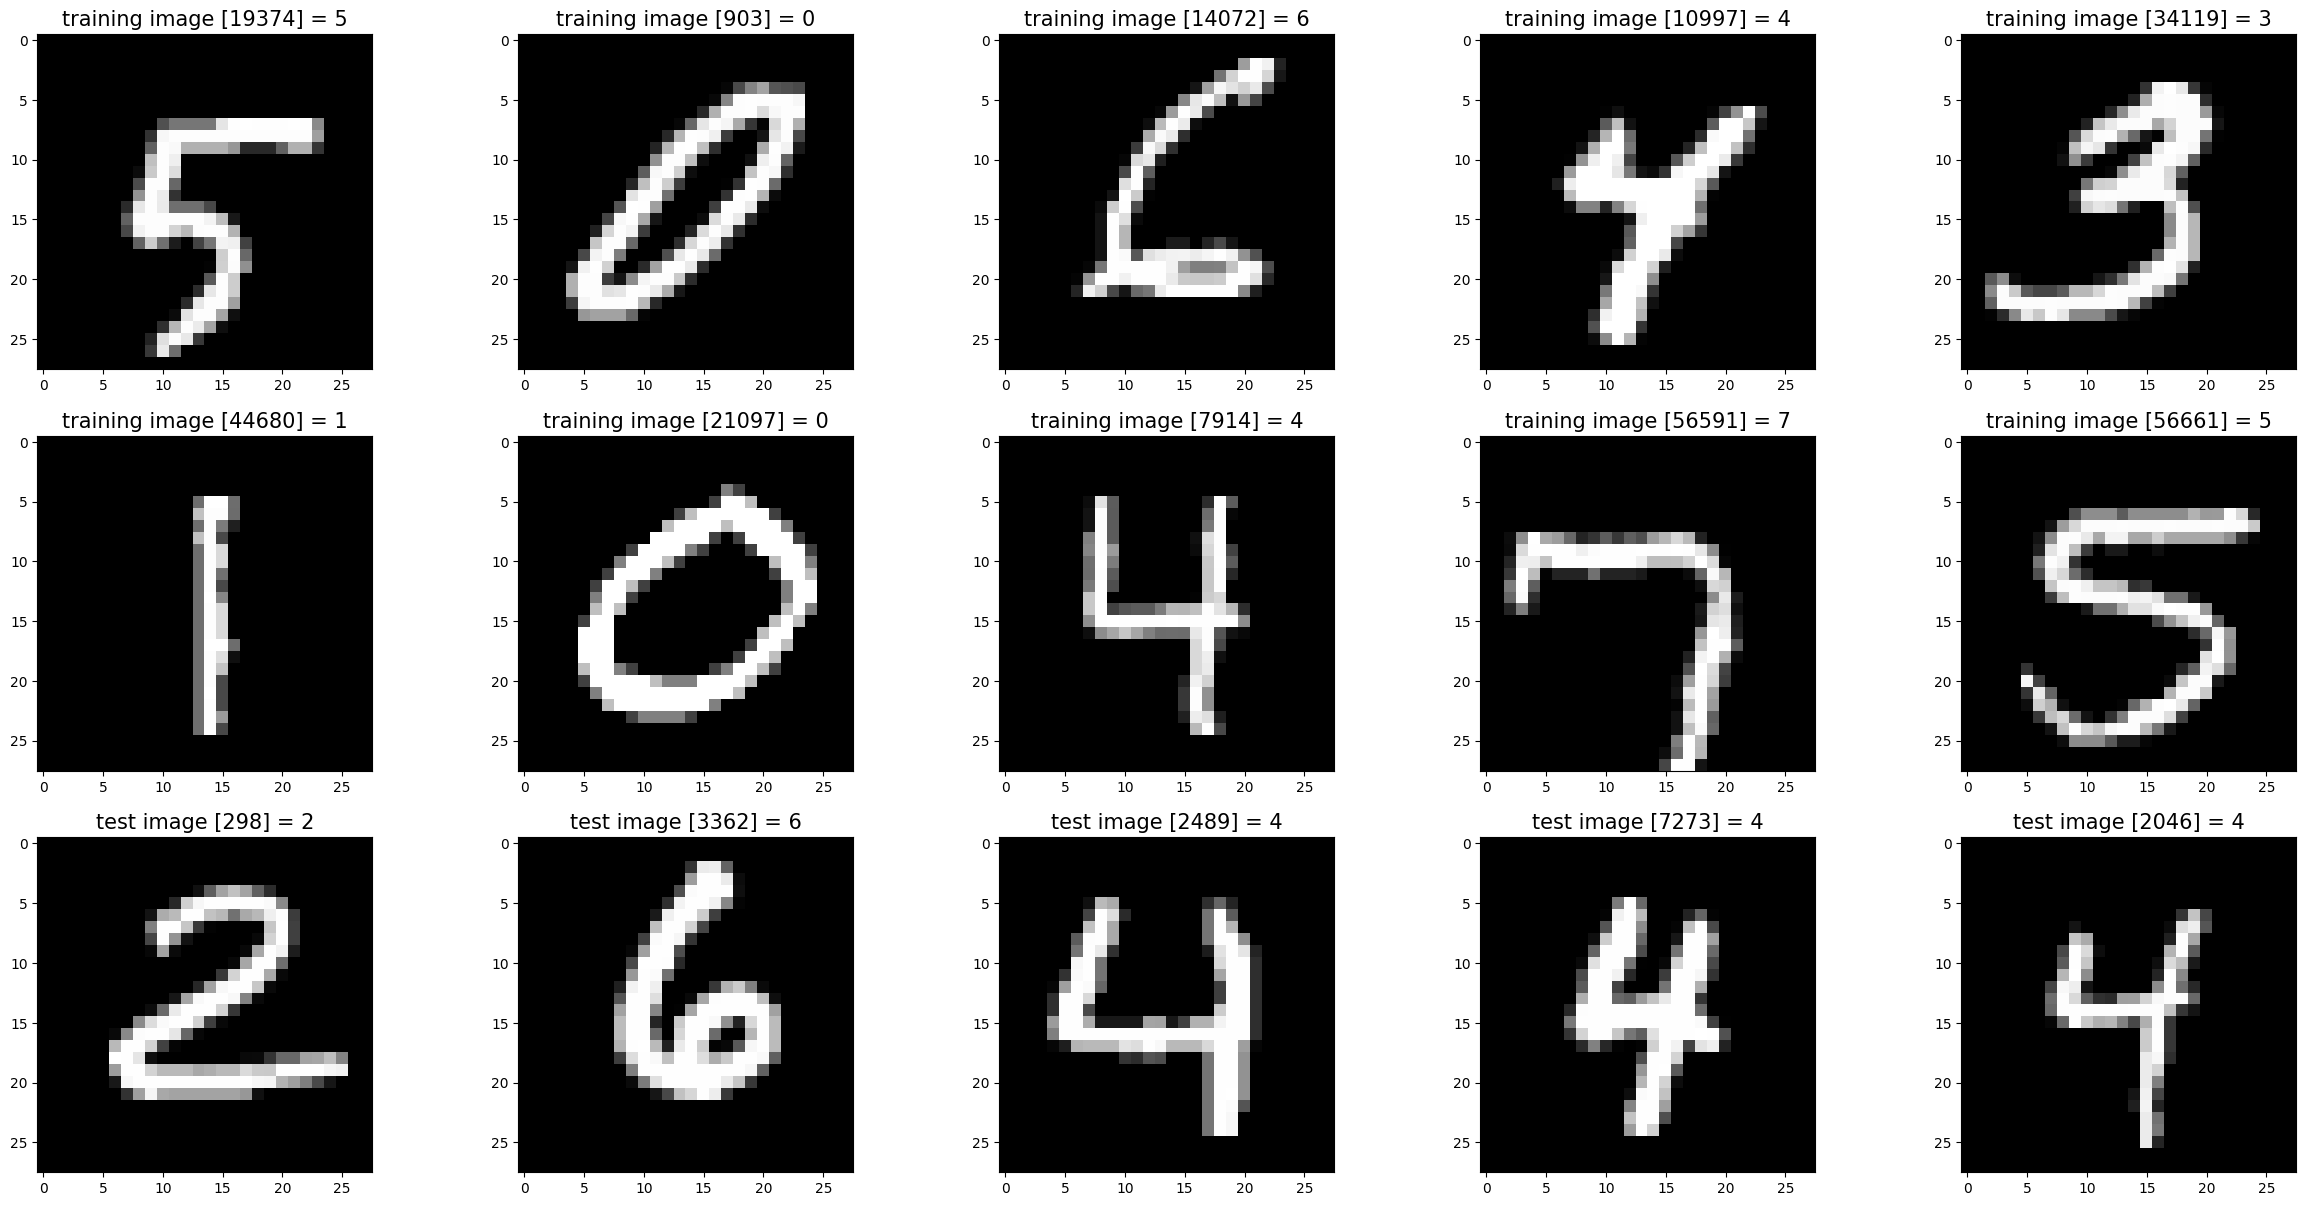

In [17]:
import random
import matplotlib.pyplot as plt # type: ignore


input_path = r'D:\Datasets\mnist' 
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Help function to show a list of images with their relating titles, mostly for verification

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [18]:
def preprocess_images(images):
    num_images = len(images)
    processed = np.zeros((num_images, 28 * 28), dtype = np.float32)

    for i, img in enumerate(images):
        flat_img = img.flatten()
        processed [i, :] = flat_img / 255.0
    return processed
    
x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        one_hot[i, label] = 1
    return one_hot

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
        
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))
        
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights_hidden_input = np.random.randn(input_size, hidden_size)
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)

    def forward(self, x):
        # calculate hidden layer weight
        self.hidden_input = np.dot(x, self.weights_hidden_input)
        self.hidden_output = sigmoid(self.hidden_input)
        
        # calc output
        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output)
        self.final_output = sigmoid(self.final_input)
        return self.final_output

    def backward(self, x, y, output, learning_rate):
        # calc error on output
        output_error = y - output
        output_delta = output_error * sigmoid_derivative(self.final_input)

        # calc error in hidden
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * sigmoid_derivative(self.hidden_input)

        # udate weights
        self.weights_hidden_output += np.dot(self.hidden_output.T, output_delta) * learning_rate
        self.weights_hidden_input += np.dot(x.T, hidden_delta) * learning_rate

    def train(self, x_train, y_train, learning_rate=0.01, epochs=1000):
        for epoch in range(epochs):
            output = self.forward(x_train)
            self.backward(x_train, y_train, output, learning_rate)
            if epoch % 100 == 0:
                loss = np.mean((y_train - output) ** 2)
                print(f'Epoch {epoch}, Loss: {loss}')
        


In [ ]:

#Load MNIST
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, 
                                   test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Preprocess the images: flatten and normalize
x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

# One-hot encode labels for the classification (we use 10 because MNIST goes from 0-9)
y_train_encoded = one_hot_encode(y_train, num_classes=10)
y_test_encoded = one_hot_encode(y_test, num_classes=10)

input_size = 28 * 28     # Each image is 28x28 pixels
hidden_size = 64         # might change hidden size
output_size = 10         # 10 classes for digits 0-9

# Instantiate the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Training hyperparameters
learning_rate = 0.1
epochs = 1000

# Start training
nn.train(x_train_processed, y_train_encoded, learning_rate=learning_rate, epochs=epochs)

# See the final predictions on some test data:
predictions = nn.forward(x_test_processed)
predicted_labels = np.argmax(predictions, axis=1)
print("Sample predicted labels:", predicted_labels[:10])

Epoch 0, Loss: 0.26567850795350617


C:\Users\Johan\AppData\Local\Temp\ipykernel_27456\3972497405.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100, Loss: 0.18193
Epoch 200, Loss: 0.18193
